***
# **Cas fictif** : Supermarket sales

***

### Étapes : 
1. Nettoyage
2. Analyse exploratoire
3. Data processing / Feature engineering
4. Clustering
5. Recommendations 
***

### Mise en place du répertoire

In [3]:
# Create folders and getting path
import os
cwd = os.getcwd()

# Loop to create folders
folder_names = ['Dataframe', 'Output', 'Data']

folders = {}
for folder_name in folder_names:
    folders[folder_name] = os.path.join(cwd, folder_name)

    if not os.path.exists(os.path.join(cwd, folder_name)):
        os.makedirs(os.path.join(cwd, folder_name))
        print(f'Le dossier « {folder_name} » a été créé')

    else:
        print(f'Le dossier « {folder_name} » est existant')

Le dossier « Dataframe » est existant
Le dossier « Output » est existant
Le dossier « Data » est existant


In [4]:
# Création des variables de path

# Déterminer si os est win ou linux pour définir les path
if os.name == 'nt':
    slash = '\\'
elif os.name == 'posix':
    slash = '/'

path_prog =     cwd + slash
path_data =     folders['Data'] + slash
path_df =       folders['Dataframe'] + slash
path_output =   folders['Output'] + slash

# Mettre \\ pour éviter les erreurs
path_dict = [path_prog, path_data, path_df, path_output]
for path in path_dict:
    path = path.replace('\\','\\\\')


# Détermination de l'année
print(path_prog)
print(path_data)
print(path_df)
print(path_output)

c:\Users\Charles_tour\Documents\GitHub\clustering\
c:\Users\Charles_tour\Documents\GitHub\clustering\Data\
c:\Users\Charles_tour\Documents\GitHub\clustering\Dataframe\
c:\Users\Charles_tour\Documents\GitHub\clustering\Output\


***
# 1. Nettoyage des données
***

In [5]:
# Source des données
# https://www.kaggle.com/datasets/aungpyaeap/supermarket-sales

import pandas as pd
pd.set_option('display.max_columns', None)

df = pd.read_csv(path_data + 'supermarket_sales.csv', index_col=0)
df.head(2)

,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
Invoice ID,,,,,,,,,,,,,,,,
750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6


In [6]:
# Cleaning column names
print(df.columns.tolist())
df.columns = df.columns.str.rstrip().str.replace('-', '_').str.replace(' ', '_').str.replace('%', '').str.lower()
print(df.columns.tolist())

['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Unit price', 'Quantity', 'Tax 5%', 'Total', 'Date', 'Time', 'Payment', 'cogs', 'gross margin percentage', 'gross income', 'Rating']
['branch', 'city', 'customer_type', 'gender', 'product_line', 'unit_price', 'quantity', 'tax_5', 'total', 'date', 'time', 'payment', 'cogs', 'gross_margin_percentage', 'gross_income', 'rating']


In [7]:
# Data type
df.dtypes

branch                      object
city                        object
customer_type               object
gender                      object
product_line                object
unit_price                 float64
quantity                     int64
tax_5                      float64
total                      float64
date                        object
time                        object
payment                     object
cogs                       float64
gross_margin_percentage    float64
gross_income               float64
rating                     float64
dtype: object

In [8]:
# Unique values
print('Unique values')
print("-" * 25)
for column in df.columns:
    unique_values = ", ".join(map(str, df[column].unique()[:5]))
    print(f"{column.ljust(25)}: {unique_values}")

Unique values
-------------------------
branch                   : A, C, B
city                     : Yangon, Naypyitaw, Mandalay
customer_type            : Member, Normal
gender                   : Female, Male
product_line             : Health and beauty, Electronic accessories, Home and lifestyle, Sports and travel, Food and beverages
unit_price               : 74.69, 15.28, 46.33, 58.22, 86.31
quantity                 : 7, 5, 8, 6, 10
tax_5                    : 26.1415, 3.82, 16.2155, 23.288, 30.2085
total                    : 548.9715, 80.22, 340.5255, 489.048, 634.3785
date                     : 1/5/2019, 3/8/2019, 3/3/2019, 1/27/2019, 2/8/2019
time                     : 13:08, 10:29, 13:23, 20:33, 10:37
payment                  : Ewallet, Cash, Credit card
cogs                     : 522.83, 76.4, 324.31, 465.76, 604.17
gross_margin_percentage  : 4.761904762
gross_income             : 26.1415, 3.82, 16.2155, 23.288, 30.2085
rating                   : 9.1, 9.6, 7.4, 8.4, 5.3


In [9]:
# Missing values
print('Nombre d\'obersvations : ', len(df))
print()
print('Missing values')
print('-'*25)
df.isna().sum()

Nombre d'obersvations :  1000

Missing values
-------------------------


branch                     0
city                       0
customer_type              0
gender                     0
product_line               0
unit_price                 0
quantity                   0
tax_5                      0
total                      0
date                       0
time                       0
payment                    0
cogs                       0
gross_margin_percentage    0
gross_income               0
rating                     0
dtype: int64

In [10]:
# Adjuste date format
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
print(df['date'].head(2))

Invoice ID
750-67-8428   2019-01-05
226-31-3081   2019-03-08
Name: date, dtype: datetime64[ns]


In [11]:
# Save after cleaning
df.to_hdf(path_df + 'df.h5', key='s')

***
# 2. Analyse descriptive (EDA)
***

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [13]:
df = pd.read_hdf(path_df + 'df.h5', key='s')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 750-67-8428 to 849-09-3807
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   branch                   1000 non-null   object        
 1   city                     1000 non-null   object        
 2   customer_type            1000 non-null   object        
 3   gender                   1000 non-null   object        
 4   product_line             1000 non-null   object        
 5   unit_price               1000 non-null   float64       
 6   quantity                 1000 non-null   int64         
 7   tax_5                    1000 non-null   float64       
 8   total                    1000 non-null   float64       
 9   date                     1000 non-null   datetime64[ns]
 10  time                     1000 non-null   object        
 11  payment                  1000 non-null   object        
 12  cogs                  

In [14]:
# Période 
period_start = df['date'].min()
period_end = df['date'].max()

print(f'Date de début des observations : {period_start}')
print(f'Date de fin des observations : {period_end}')

# Nombre d'observation
print(f'Nombre d\'observation : {len(df)}')

Date de début des observations : 2019-01-01 00:00:00
Date de fin des observations : 2019-03-30 00:00:00
Nombre d'observation : 1000


### Variables quantitatives
***

In [15]:
# Colonnes numérique et qualitative
col_num = ['unit_price', 'quantity', 'tax_5', 'total', 'cogs', 'gross_margin_percentage', 'gross_income', 'rating']
col_quali = ['branch', 'city', 'customer_type', 'gender', 'product_line', 'payment']

# Describe
df.describe().to_excel(path_output + 'describe.xlsx')
df.describe()

,unit_price,quantity,tax_5,total,cogs,gross_margin_percentage,gross_income,rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,307.58738,4.761905,15.379369,6.97270
std,26.494628,2.923431,11.708825,245.885335,234.17651,0.000000,11.708825,1.71858
min,10.080000,1.000000,0.508500,10.678500,10.17000,4.761905,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,118.49750,4.761905,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,241.76000,4.761905,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,448.90500,4.761905,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,993.00000,4.761905,49.650000,10.00000


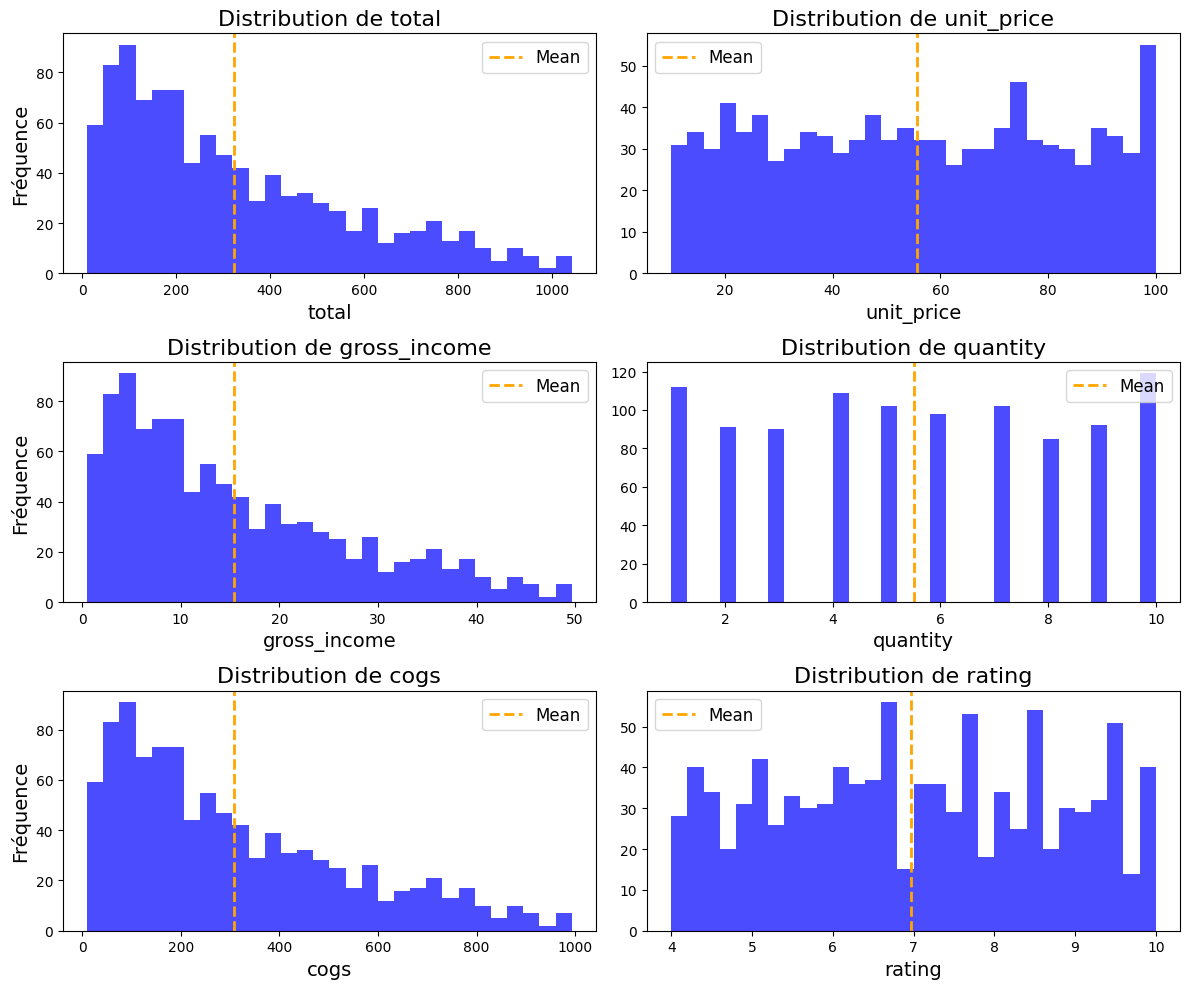

In [16]:
# Plot distribution
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

numerical_columns = ['total', 'unit_price', 'gross_income', 'quantity', 'cogs', 'rating']

for idx, column in enumerate(numerical_columns):
    row = idx // 2
    col = idx % 2
    
    axes[row, col].hist(df[column], bins=30, color='blue', alpha=0.7)
    axes[row, col].axvline(df[column].mean(), color='orange', linestyle='dashed', linewidth=2, label='Mean')
    axes[row, col].set_xlabel(column, fontsize=14)  
    if col == 0:
        axes[row, col].set_ylabel('Fréquence', fontsize=14) 
    axes[row, col].set_title(f'Distribution de {column}', fontsize=16) 
    axes[row, col].legend(fontsize=12) 

plt.tight_layout()
plt.savefig(path_output + 'numerical_data_with_mean.png')
plt.show()


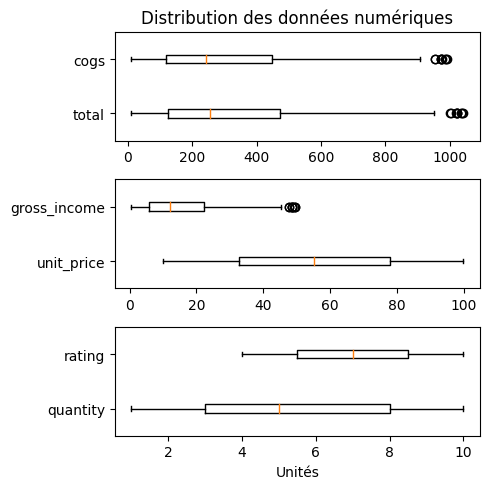

In [17]:
# Box plot
import matplotlib.pyplot as plt

row1 = ['total', 'cogs']
row2 = ['unit_price', 'gross_income']
row3 = ['quantity', 'rating']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 5))

axes[0].boxplot(df[row1], vert=False, labels=row1)
axes[0].set_title('Distribution des données numériques')

axes[1].boxplot(df[row2], vert=False, labels=row2)

axes[2].boxplot(df[row3], vert=False, labels=row3)
axes[2].set_xlabel('Unités')


plt.tight_layout()
plt.savefig(path_output + 'numerical_data_boxplot.png')
plt.show()

### Variables qualitatives
***

In [18]:
# Nombre d'observation par valeurs des variables qualitatives
print('Nombre d\'observations par variables')
print('-'*35)
print(df['branch'].value_counts())
print('-'*35)
print(df['city'].value_counts())
print('-'*35)
print(df['customer_type'].value_counts())
print('-'*35)
print(df['product_line'].value_counts())
print('-'*35)
print(df['payment'].value_counts())
print('-'*35)

Nombre d'observations par variables
-----------------------------------
A    340
B    332
C    328
Name: branch, dtype: int64
-----------------------------------
Yangon       340
Mandalay     332
Naypyitaw    328
Name: city, dtype: int64
-----------------------------------
Member    501
Normal    499
Name: customer_type, dtype: int64
-----------------------------------
Fashion accessories       178
Food and beverages        174
Electronic accessories    170
Sports and travel         166
Home and lifestyle        160
Health and beauty         152
Name: product_line, dtype: int64
-----------------------------------
Ewallet        345
Cash           344
Credit card    311
Name: payment, dtype: int64
-----------------------------------


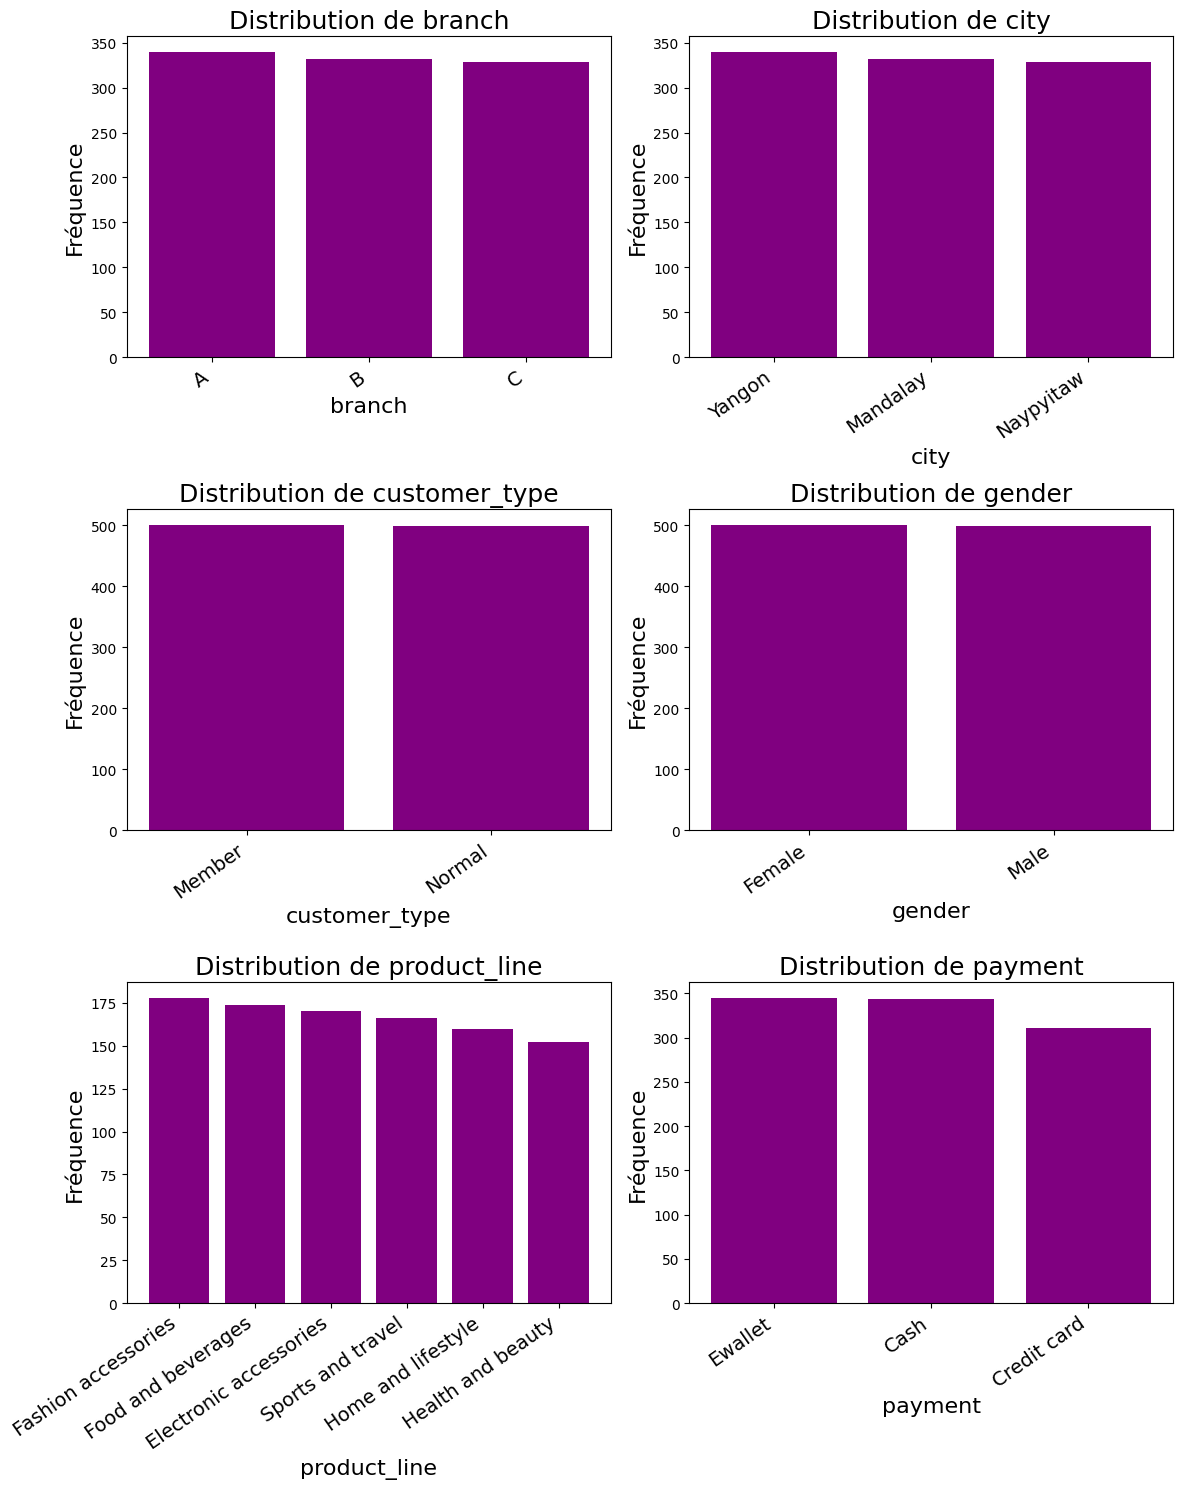

In [19]:
# Calculate the number of rows and columns for subplots
num_plots = len(col_quali)
num_cols = 2
num_rows = (num_plots + 1) // num_cols

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 5 * num_rows))

# Flatten the axes array if there's only one row of subplots
if num_rows == 1:
    axes = [axes]

# Create bar plots for each categorical column
for i, column in enumerate(col_quali):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row][col]

    counts = df[column].value_counts()
    ax.bar(counts.index, counts.values, color='purple')
    
    ax.set_xlabel(column, fontsize=16) 
    ax.set_ylabel('Fréquence', fontsize=16) 
    ax.set_title(f'Distribution de {column}', fontsize=18)
    ax.tick_params(axis='x', rotation=35, labelsize=12)

    ax.set_xticks(range(len(counts)))
    ax.set_xticklabels(counts.index, rotation=35, ha='right', fontsize=14)  
    
plt.tight_layout()
plt.savefig(path_output + 'categorical_data.png')
plt.show()


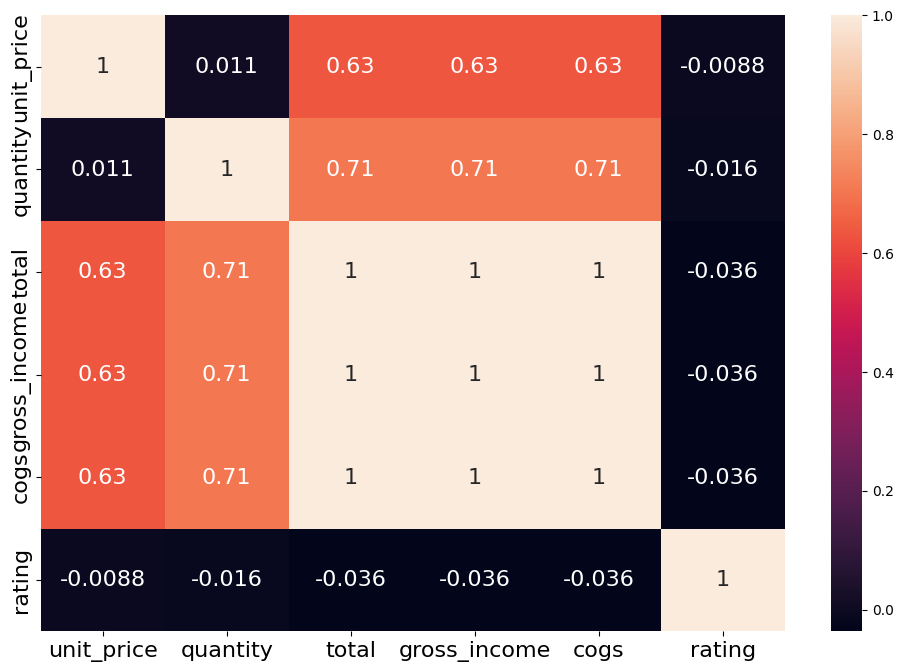

In [20]:
# Corrélation
import seaborn as sns

cols = ['unit_price', 'quantity', 'total', 'gross_income', 'cogs', 'rating']

plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(df[cols].corr(), annot=True, annot_kws={'fontsize': 16})
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=16)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=16)

plt.savefig(path_output + 'correlation.png')
plt.show()

### Variables de temps
***

In [21]:
df.head()

,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating
Invoice ID,,,,,,,,,,,,,,,,
750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08,Ewallet,522.83,4.761905,26.1415,9.1
226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29,Cash,76.40,4.761905,3.8200,9.6
631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13:23,Credit card,324.31,4.761905,16.2155,7.4
123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20:33,Ewallet,465.76,4.761905,23.2880,8.4
373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10:37,Ewallet,604.17,4.761905,30.2085,5.3


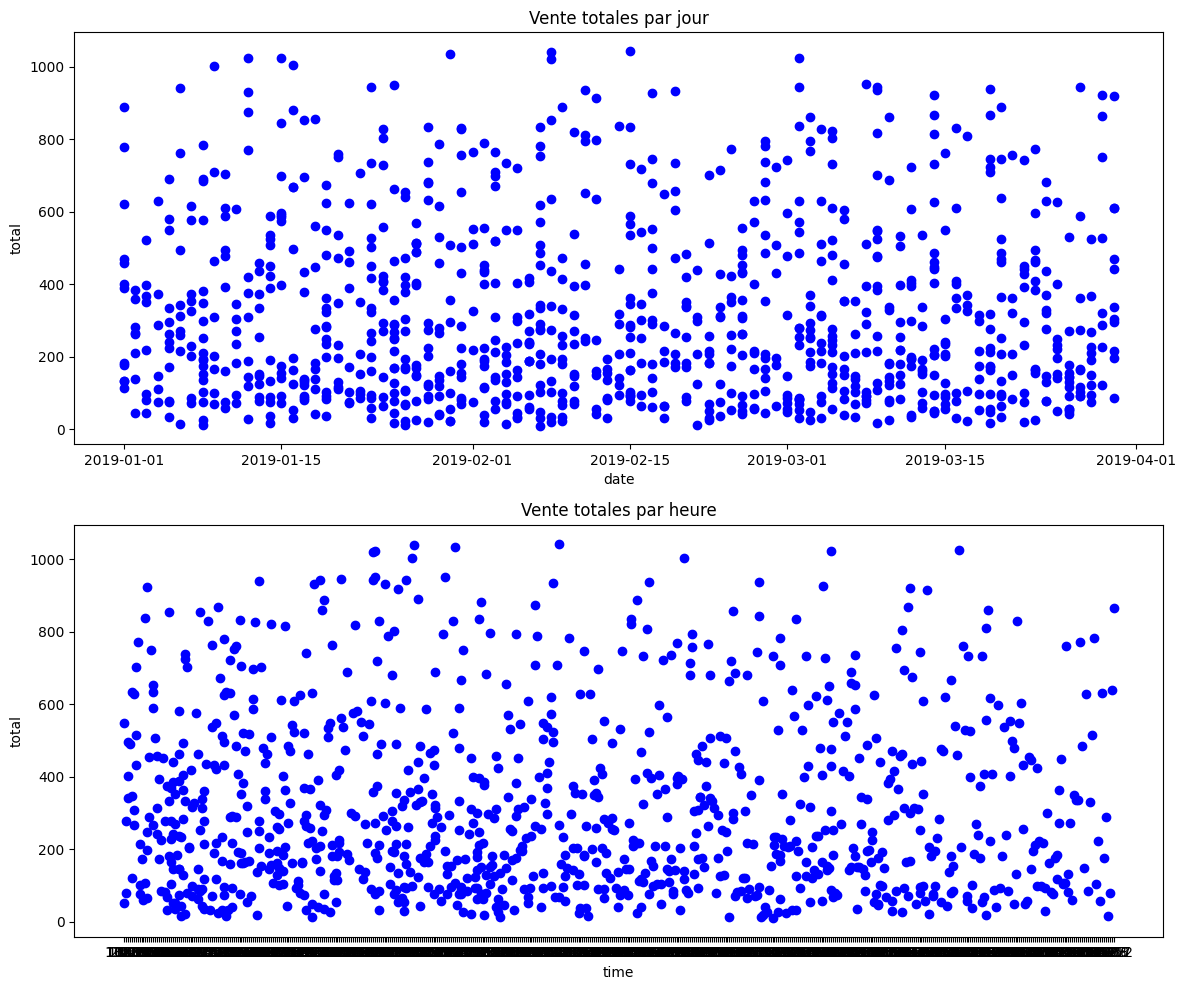

In [22]:
# Plot distribution
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

axes[0].scatter(df['date'], df['total'], color='blue', marker='o', label='Total')
axes[0].set_xlabel('date')
axes[0].set_ylabel('total')
axes[0].set_title('Vente totales par jour')

axes[1].scatter(df['time'], df['total'], color='blue', marker='o', label='Total')
axes[1].set_xlabel('time')
axes[1].set_ylabel('total')
axes[1].set_title('Vente totales par heure')

plt.tight_layout()
plt.savefig(path_output + 'time_data.png')
plt.show()

*** 
# 3. Feature engineering
***

In [23]:
df = pd.read_hdf(path_df + 'df.h5', key='s')
df.head(2)

,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating
Invoice ID,,,,,,,,,,,,,,,,
750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08,Ewallet,522.83,4.761905,26.1415,9.1
226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29,Cash,76.40,4.761905,3.8200,9.6


In [24]:
# Creer des variables day of the week and month
df['dayofweek'] = df['date'].dt.day_name()
df['month'] = df['date'].dt.month_name()
df.head(2)

,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating,dayofweek,month
Invoice ID,,,,,,,,,,,,,,,,,,
750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08,Ewallet,522.83,4.761905,26.1415,9.1,Saturday,January
226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29,Cash,76.40,4.761905,3.8200,9.6,Friday,March


### Encoding categorical data
***

In [25]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder
col_quali = ['branch', 'city', 'customer_type', 'gender', 'product_line', 'payment']

encoded_columns = pd.get_dummies(df[col_quali])
df_encoded = pd.concat([df, encoded_columns], axis=1)

df_encoded.head(2)

,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating,dayofweek,month,branch_A,branch_B,branch_C,city_Mandalay,city_Naypyitaw,city_Yangon,customer_type_Member,customer_type_Normal,gender_Female,gender_Male,product_line_Electronic accessories,product_line_Fashion accessories,product_line_Food and beverages,product_line_Health and beauty,product_line_Home and lifestyle,product_line_Sports and travel,payment_Cash,payment_Credit card,payment_Ewallet
Invoice ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08,Ewallet,522.83,4.761905,26.1415,9.1,Saturday,January,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1
226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29,Cash,76.40,4.761905,3.8200,9.6,Friday,March,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0


### sclaling data
***

In [26]:
# Scaling
from sklearn.preprocessing import MinMaxScaler

col_numerical = ['unit_price', 'quantity', 'total']
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(df_encoded[col_numerical])
scaled_columns = [f'{col}_scaled' for col in col_numerical]
df_encoded[scaled_columns] = scaled_data

df_encoded.to_hdf(path_df + 'df_encoded.h5', key='s')
df_encoded.head(2)

,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating,dayofweek,month,branch_A,branch_B,branch_C,city_Mandalay,city_Naypyitaw,city_Yangon,customer_type_Member,customer_type_Normal,gender_Female,gender_Male,product_line_Electronic accessories,product_line_Fashion accessories,product_line_Food and beverages,product_line_Health and beauty,product_line_Home and lifestyle,product_line_Sports and travel,payment_Cash,payment_Credit card,payment_Ewallet,unit_price_scaled,quantity_scaled,total_scaled
Invoice ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08,Ewallet,522.83,4.761905,26.1415,9.1,Saturday,January,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0.718847,0.666667,0.521616
226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29,Cash,76.40,4.761905,3.8200,9.6,Friday,March,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0.057855,0.444444,0.067387


In [27]:
print(df_encoded.columns.tolist())

['branch', 'city', 'customer_type', 'gender', 'product_line', 'unit_price', 'quantity', 'tax_5', 'total', 'date', 'time', 'payment', 'cogs', 'gross_margin_percentage', 'gross_income', 'rating', 'dayofweek', 'month', 'branch_A', 'branch_B', 'branch_C', 'city_Mandalay', 'city_Naypyitaw', 'city_Yangon', 'customer_type_Member', 'customer_type_Normal', 'gender_Female', 'gender_Male', 'product_line_Electronic accessories', 'product_line_Fashion accessories', 'product_line_Food and beverages', 'product_line_Health and beauty', 'product_line_Home and lifestyle', 'product_line_Sports and travel', 'payment_Cash', 'payment_Credit card', 'payment_Ewallet', 'unit_price_scaled', 'quantity_scaled', 'total_scaled']


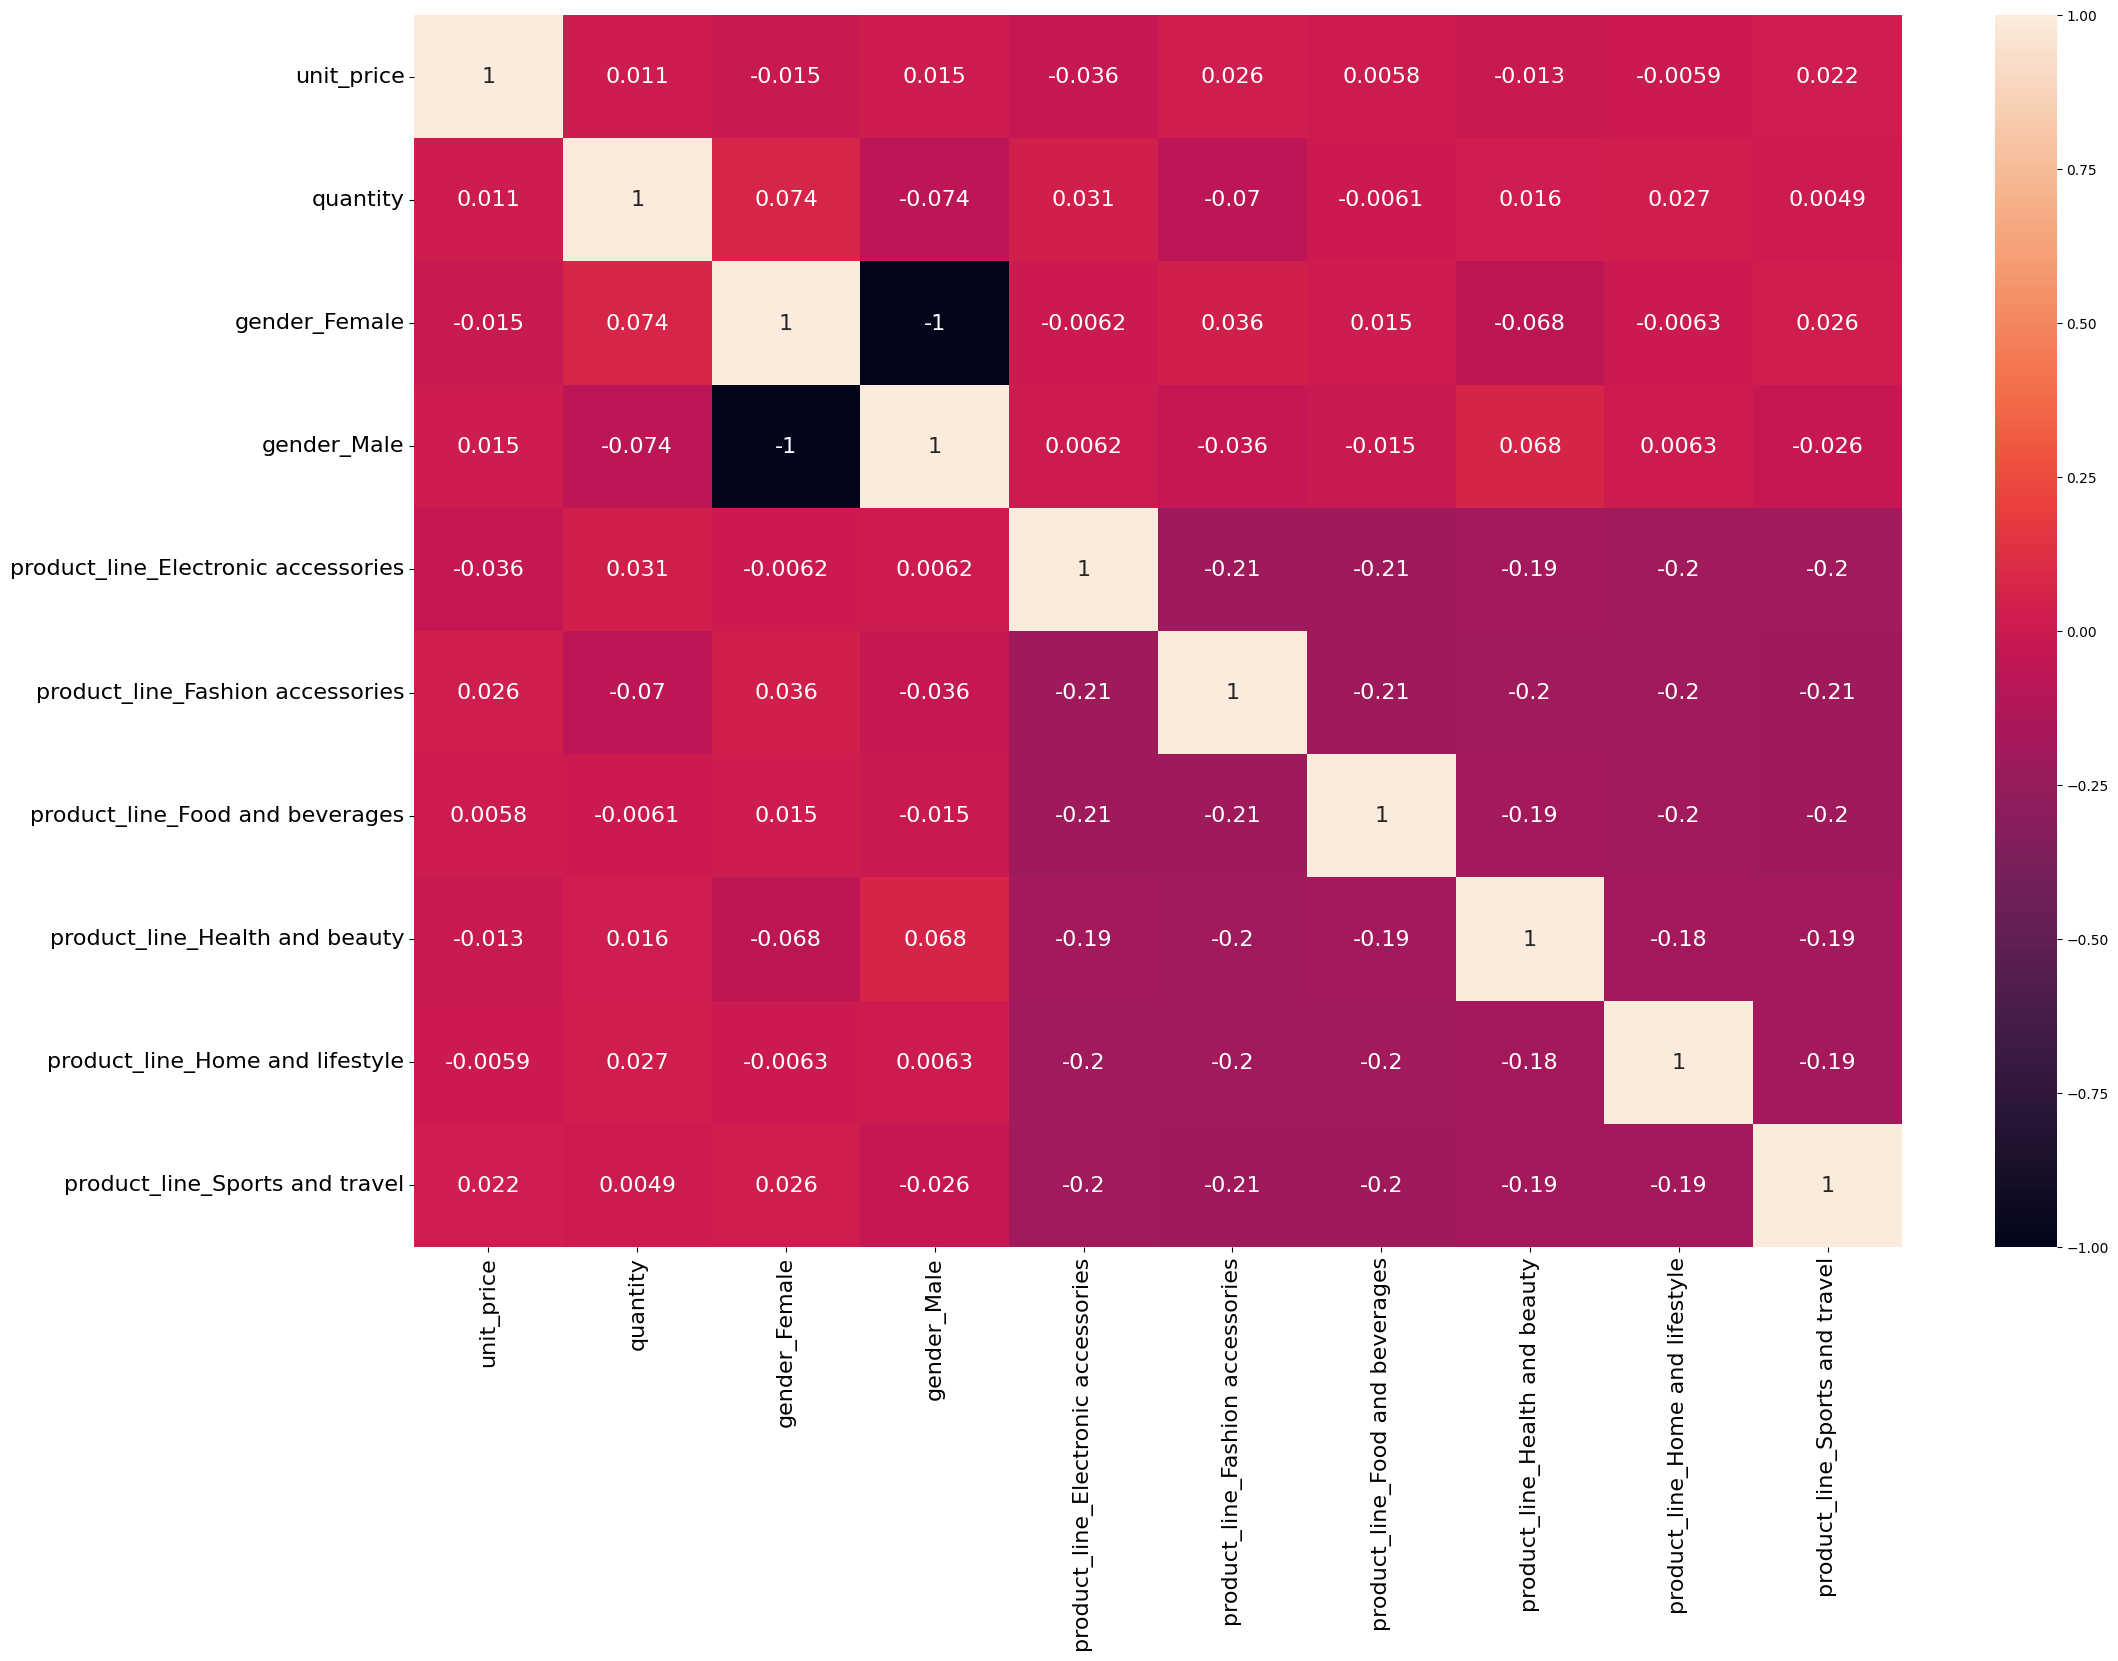

In [28]:
col1 = ['unit_price', 'quantity', 'branch_A', 'branch_B', 'branch_C', 
        'city_Mandalay', 'city_Naypyitaw', 'city_Yangon', 
        'customer_type_Member', 'customer_type_Normal']

col2 = ['unit_price', 'quantity', 'gender_Female', 'gender_Male', 'product_line_Electronic accessories', 
        'product_line_Fashion accessories', 'product_line_Food and beverages', 'product_line_Health and beauty', 
        'product_line_Home and lifestyle', 'product_line_Sports and travel']

col3 = ['unit_price', 'quantity', 'payment_Cash', 'payment_Credit card', 'payment_Ewallet']

plt.figure(figsize=(24, 16))
heatmap = sns.heatmap(df_encoded[col2].corr(), annot=True, annot_kws={'fontsize': 16})
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=16)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=16)

# plt.savefig(path_output + 'correlation.png')
plt.show()

***
# **Customer Segmentation** with Clustering
***

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
df_encoded = pd.read_hdf(path_df + 'df_encoded.h5', key='s')

# Features for clustering
features_for_clustering = ['rating', 'branch_A', 'branch_B', 'branch_C', 'city_Mandalay', 'city_Naypyitaw', 'city_Yangon',
                        'customer_type_Member', 'customer_type_Normal', 'gender_Female', 'gender_Male', 'product_line_Electronic accessories', 
                        'product_line_Fashion accessories', 'product_line_Food and beverages', 'product_line_Health and beauty', 'product_line_Home and lifestyle', 
                        'product_line_Sports and travel', 'payment_Cash', 'payment_Credit card', 'payment_Ewallet', 'unit_price_scaled', 'quantity_scaled']

# Perform PCA
pca = PCA(n_components=2) 
data_pca = pca.fit_transform(df_encoded[features_for_clustering])

K = range(2, 10)

inertia = []
silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca)  # Use PCA-transformed data
    df_encoded[f'cluster_{k}'] = kmeans.labels_
    inertia.append(kmeans.inertia_)
    
    # Silhouette score
    silhouette_avg = silhouette_score(data_pca, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

    print(f"For {k} clusters, Silhouette Score: {silhouette_avg:.2f}")

For 2 clusters, Silhouette Score: 0.49
For 3 clusters, Silhouette Score: 0.39
For 4 clusters, Silhouette Score: 0.43
For 5 clusters, Silhouette Score: 0.46
For 6 clusters, Silhouette Score: 0.49
For 7 clusters, Silhouette Score: 0.49
For 8 clusters, Silhouette Score: 0.49
For 9 clusters, Silhouette Score: 0.47


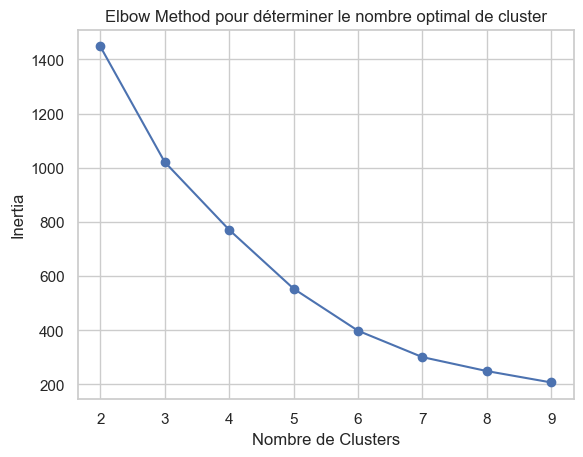

In [69]:
# Elbow curve
plt.plot(K, inertia, marker='o')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method pour déterminer le nombre optimal de cluster')
plt.savefig(path_output + 'Elbow.png')
plt.show()

# Choisir le point où l'inertie devient 'stable'

In [30]:
# Éliminer les colonnes des cluster non-choisis
nb_cluster_optimal = 6
range_to_delete = [k for k in range(2, 10) if k != nb_cluster_optimal]

for i in range_to_delete:
    df_encoded = df_encoded.drop(columns=f'cluster_{i}')

df_encoded.rename(columns={f'cluster_{nb_cluster_optimal}': 'cluster'}, inplace=True)

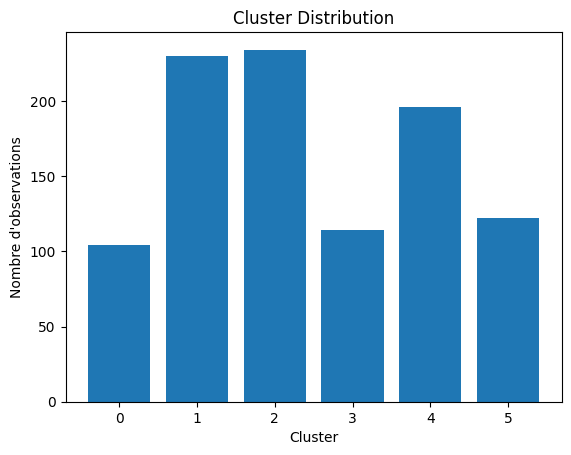

In [31]:
cluster_counts = df_encoded['cluster'].value_counts()

# Create a bar plot
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Nombre d\'observations')
plt.title('Cluster Distribution')
plt.savefig(path_output + 'cluster_distribution.png')
plt.show()

In [32]:
# Regarder les variables selon les clusters
columns_to_monitor = ['unit_price', 'quantity', 'total', 'rating', 
                        'branch_A', 'branch_B', 'branch_C', 'city_Mandalay', 'city_Naypyitaw', 'city_Yangon',
                        'customer_type_Member', 'customer_type_Normal', 'gender_Female', 'gender_Male', 'product_line_Electronic accessories', 
                        'product_line_Fashion accessories', 'product_line_Food and beverages', 'product_line_Health and beauty', 'product_line_Home and lifestyle', 
                        'product_line_Sports and travel', 'payment_Cash', 'payment_Credit card', 'payment_Ewallet',
                    ]
                    
cluster_profiles = df_encoded.groupby('cluster')[columns_to_monitor].mean()
# cluster_profiles.to_excel(path_output + 'cluster_profiles.xlsx')
cluster_profiles

,unit_price,quantity,total,rating,branch_A,branch_B,branch_C,city_Mandalay,city_Naypyitaw,city_Yangon,customer_type_Member,customer_type_Normal,gender_Female,gender_Male,product_line_Electronic accessories,product_line_Fashion accessories,product_line_Food and beverages,product_line_Health and beauty,product_line_Home and lifestyle,product_line_Sports and travel,payment_Cash,payment_Credit card,payment_Ewallet
cluster,,,,,,,,,,,,,,,,,,,,,,,
0,53.835865,5.355769,297.512957,9.100962,1.0,0.000000,0.000000,0.000000,0.000000,1.0,0.509615,0.490385,0.413462,0.586538,0.144231,0.105769,0.211538,0.144231,0.201923,0.192308,0.307692,0.307692,0.384615
1,54.902087,5.304348,303.950439,6.748696,0.0,0.517391,0.482609,0.517391,0.482609,0.0,0.482609,0.517391,0.482609,0.517391,0.182609,0.186957,0.182609,0.134783,0.139130,0.173913,0.395652,0.269565,0.334783
2,56.379487,5.598291,329.719519,8.867949,0.0,0.448718,0.551282,0.448718,0.551282,0.0,0.500000,0.500000,0.555556,0.444444,0.158120,0.209402,0.188034,0.183761,0.132479,0.128205,0.333333,0.358974,0.307692
3,55.309386,5.535088,314.581013,5.028947,1.0,0.000000,0.000000,0.000000,0.000000,1.0,0.517544,0.482456,0.482456,0.517544,0.192982,0.149123,0.149123,0.157895,0.210526,0.140351,0.368421,0.298246,0.333333
4,57.277347,5.719388,355.629643,4.878571,0.0,0.551020,0.448980,0.551020,0.448980,0.0,0.540816,0.459184,0.505102,0.494898,0.158163,0.178571,0.153061,0.158163,0.163265,0.188776,0.331633,0.311224,0.357143
5,55.092541,5.500000,322.924488,7.126230,1.0,0.000000,0.000000,0.000000,0.000000,1.0,0.450820,0.549180,0.516393,0.483607,0.188525,0.188525,0.155738,0.114754,0.163934,0.188525,0.295082,0.311475,0.393443


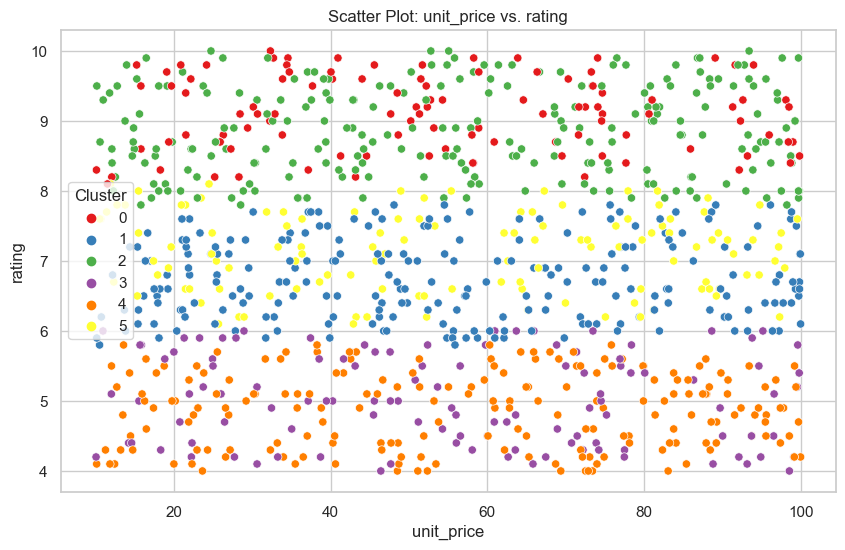

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Features d'intérêt
feature_x = 'unit_price'
feature_y = 'rating'

# Create scatter plot with cluster assignments
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_encoded, x=feature_x, y=feature_y, hue='cluster', palette='Set1')
plt.title(f'Scatter Plot: {feature_x} vs. {feature_y}')
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.legend(title='Cluster')
plt.savefig(path_output + 'cluster_unit_price.png')
plt.show()

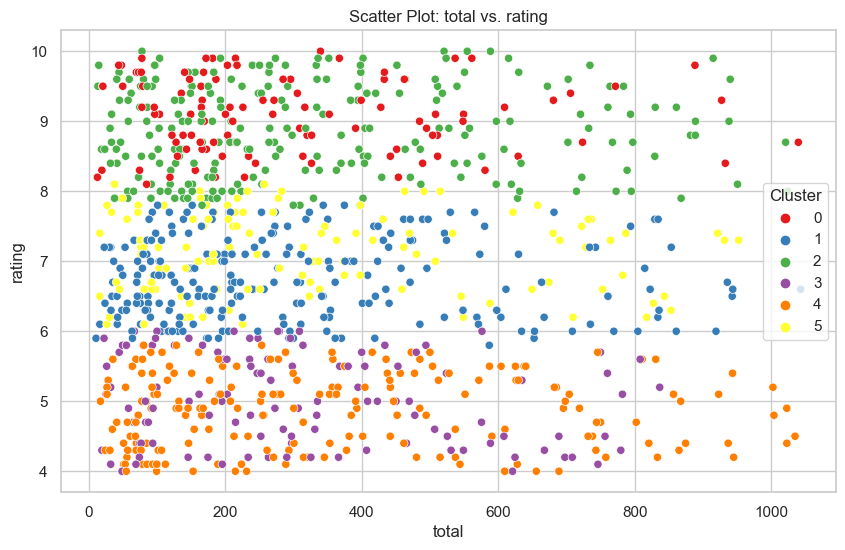

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plots
sns.set(style="whitegrid")

# Choose two features for the scatter plots
feature_x = 'total'
feature_y = 'rating'

# Create scatter plot with cluster assignments
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_encoded, x=feature_x, y=feature_y, hue='cluster', palette='Set1')
plt.title(f'Scatter Plot: {feature_x} vs. {feature_y}')
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.legend(title='Cluster')
plt.savefig(path_output + 'cluster_total.png')
plt.show()

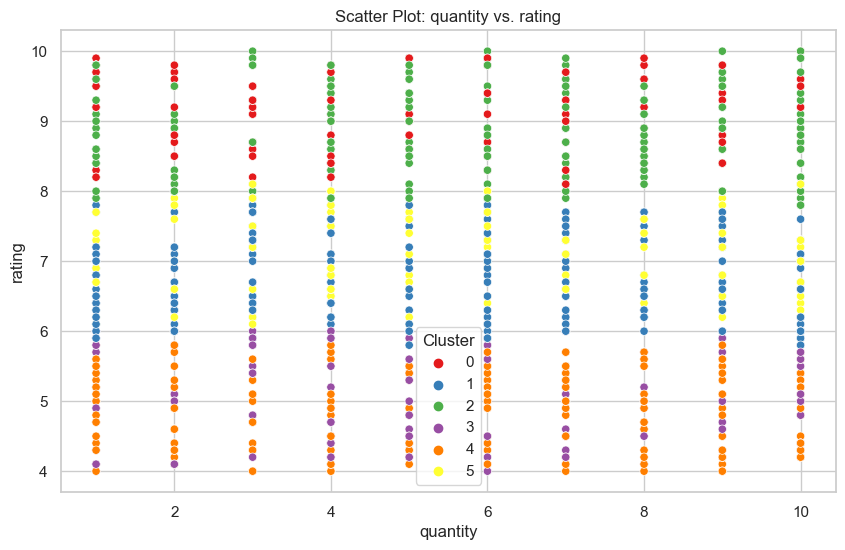

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plots
sns.set(style="whitegrid")

# Choose two features for the scatter plots
feature_x = 'quantity'
feature_y = 'rating'

# Create scatter plot with cluster assignments
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_encoded, x=feature_x, y=feature_y, hue='cluster', palette='Set1')
plt.title(f'Scatter Plot: {feature_x} vs. {feature_y}')
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.legend(title='Cluster')
plt.savefig(path_output + 'cluster_quantity.png')
plt.show()

***